# Setup
First we need to install keras_cv and import any packages we will use.

In [1]:
!pip install git+https://github.com/keras-team/keras-cv -q

In [2]:
import keras_cv
from keras_cv.metrics import coco
import tensorflow as tf
import math
import numpy as np
import random

Next we need to produce random bounding boxes to benchmark against.

In [3]:
def produce_random_data(include_confidence=False, num_images=128, num_classes=20):
    """Generates a fake list of bounding boxes for use in this test.

    Returns:
      a tensor list of size [128, 25, 5/6].  This represents 128 images, 25 bboxes
        and 5/6 dimensions to represent each bbox depending on if confidence is
        set.
    """
    images = []
    for _ in range(num_images):
        num_boxes = math.floor(25 * random.uniform(0, 1))
        classes = np.floor(np.random.rand(num_boxes, 1) * num_classes)
        bboxes = np.random.rand(num_boxes, 4)
        boxes = np.concatenate([bboxes, classes], axis=-1)
        if include_confidence:
            confidence = np.random.rand(num_boxes, 1)
            boxes = np.concatenate([boxes, confidence], axis=-1)
        images.append(
            keras_cv.utils.bounding_box.xywh_to_corners(
                tf.constant(boxes, dtype=tf.float32)
            )
        )

    images = [
        keras_cv.utils.bounding_box.pad_bounding_box_batch_to_shape(
            x, [25, images[0].shape[1]]
        )
        for x in images
    ]
    return tf.stack(images, axis=0)

In [4]:
y_true = produce_random_data()
y_pred = produce_random_data(include_confidence=True)
class_ids = list(range(20))

# Gather Performance Numbers


In [5]:
n_images = [128, 256, 512, 512 + 256, 1024]

In [6]:
import time

update_state_runtimes = []
result_runtimes = []
end_to_end_runtimes = []

for images in n_images:
    y_true = produce_random_data(num_images=images)
    y_pred = produce_random_data(num_images=images, include_confidence=True)
    metric = coco.COCORecall(class_ids)
    # warm up
    metric.update_state(y_true, y_pred)
    metric.result()

    start = time.time()
    metric.update_state(y_true, y_pred)
    update_state_done = time.time()
    r = metric.result()
    end = time.time()

    update_state_runtimes.append(update_state_done - start)
    result_runtimes.append(end - update_state_done)
    end_to_end_runtimes.append(end - start)

    print("end_to_end_runtimes", end_to_end_runtimes)

end_to_end_runtimes [11.991924047470093]
end_to_end_runtimes [11.991924047470093, 10.660876035690308]
end_to_end_runtimes [11.991924047470093, 10.660876035690308, 20.445800065994263]
end_to_end_runtimes [11.991924047470093, 10.660876035690308, 20.445800065994263, 31.767057418823242]
end_to_end_runtimes [11.991924047470093, 10.660876035690308, 20.445800065994263, 31.767057418823242, 41.414693117141724]


# Generate Plots

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [8]:
data = pd.DataFrame(
    {
        "n_images": n_images,
        "update_state_runtimes": update_state_runtimes,
        "result_runtimes": result_runtimes,
        "end_to_end_runtimes": end_to_end_runtimes,
    }
)

## update_state()

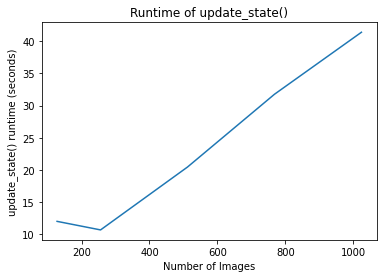

In [9]:
sns.lineplot(data=data, x="n_images", y="update_state_runtimes")
plt.xlabel("Number of Images")
plt.ylabel("update_state() runtime (seconds)")
plt.title("Runtime of update_state()")
plt.show()

## result()

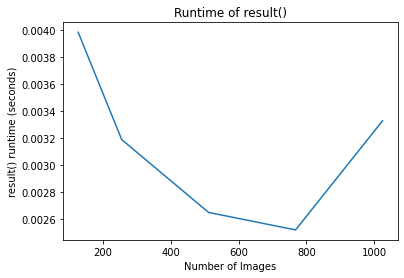

In [10]:
sns.lineplot(data=data, x="n_images", y="result_runtimes")
plt.xlabel("Number of Images")
plt.ylabel("result() runtime (seconds)")
plt.title("Runtime of result()")
plt.show()

# End to End Runs

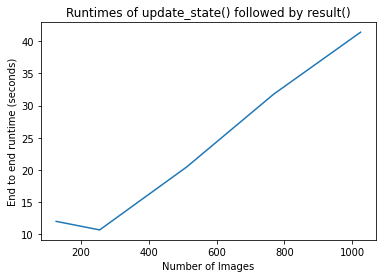

In [11]:
sns.lineplot(data=data, x="n_images", y="end_to_end_runtimes")
plt.xlabel("Number of Images")
plt.ylabel("End to end runtime (seconds)")
plt.title("Runtimes of update_state() followed by result()")
plt.show()